In [3]:
# %pip install yfinance
# %pip install matplotlib
# %pip install mplfinance
# %pip install renkodf
# %pip install commitizen

# Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import datetime as dt
import mplfinance 
from renkodf import Renko
from scipy.signal import lfilter

# Defining PSAR Fx

In [5]:
class PSAR:
   def __init__(self, start=0.02, inc=0.02, max=0.2):
       self.max_af = max
       self.init_af = start
       self.af = start
       self.af_step = inc
       self.extreme_point = None
       self.high_price_trend = []
       self.low_price_trend = []
       self.high_price_window = deque(maxlen=2)
       self.low_price_window = deque(maxlen=2)
       self.psar_list = []
       self.af_list = []
       self.ep_list = []
       self.high_list = []
       self.low_list = []
       self.trend_list = []
       self._num_days = 0

   def calcPSAR(self, high, low):
       if self._num_days >= 3:
           psar = self._calcPSAR()
       else:
           psar = self._initPSARVals(high, low)

       psar = self._updateCurrentVals(psar, high, low)
       self._num_days += 1

       return psar

   def _initPSARVals(self, high, low):
       if len(self.low_price_window) <= 1:
           self.trend = None
           self.extreme_point = high
           return None

       if self.high_price_window[0] < self.high_price_window[1]:
           self.trend = 1
           psar = min(self.low_price_window)
           self.extreme_point = max(self.high_price_window)
       else: 
           self.trend = 0
           psar = max(self.high_price_window)
           self.extreme_point = min(self.low_price_window)

       return psar

   def _calcPSAR(self):
       prev_psar = self.psar_list[-1]
       if self.trend == 1: # Up
           psar = prev_psar + self.af * (self.extreme_point - prev_psar)
           psar = min(psar, min(self.low_price_window))
       else:
           psar = prev_psar - self.af * (prev_psar - self.extreme_point)
           psar = max(psar, max(self.high_price_window))

       return psar

   def _updateCurrentVals(self, psar, high, low):
       if self.trend == 1:
           self.high_price_trend.append(high)
       elif self.trend == 0:
           self.low_price_trend.append(low)

       psar = self._trendReversal(psar, high, low)

       self.psar_list.append(psar)
       self.af_list.append(self.af)
       self.ep_list.append(self.extreme_point)
       self.high_list.append(high)
       self.low_list.append(low)
       self.high_price_window.append(high)
       self.low_price_window.append(low)
       self.trend_list.append(self.trend)

       return psar

   def _trendReversal(self, psar, high, low):
       reversal = False
       if self.trend == 1 and psar > low:
           self.trend = 0
           psar = max(self.high_price_trend)
           self.extreme_point = low
           reversal = True
       elif self.trend == 0 and psar < high:
           self.trend = 1
           psar = min(self.low_price_trend)
           self.extreme_point = high
           reversal = True

       if reversal:
           self.af = self.init_af
           self.high_price_trend.clear()
           self.low_price_trend.clear()
       else:
           if high > self.extreme_point and self.trend == 1:
               self.af = min(self.af + self.af_step, self.max_af)
               self.extreme_point = high
           elif low < self.extreme_point and self.trend == 0:
               self.af = min(self.af + self.af_step, self.max_af)
               self.extreme_point = low

       return psar

# Gathering Data

In [6]:
# collect the actual data from csv file
filename = "C:/Users/WilliamFetzner/Downloads/HISTDATA_COM_XLSX_EURUSD_M12023/DAT_XLSX_EURUSD_M1_2023.xlsx"
df = pd.read_excel(filename, header=None, names=['datetime', 'open', 'high', 'low', 'close', 'volume'])
df.head(10)

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,datetime,open,high,low,close,volume
0,2023-01-01 17:04:00,1.06970,1.06974,1.06970,1.06970,0
1,2023-01-01 17:05:00,1.06973,1.06978,1.06970,1.06971,0
2,2023-01-01 17:06:00,1.06966,1.06966,1.06966,1.06966,0
3,2023-01-01 17:08:00,1.06970,1.06974,1.06970,1.06974,0
4,2023-01-01 17:10:00,1.06975,1.06980,1.06972,1.06972,0
5,2023-01-01 17:11:00,1.06972,1.06972,1.06972,1.06972,0
6,2023-01-01 17:12:00,1.06975,1.06980,1.06975,1.06980,0
7,2023-01-01 17:13:00,1.07066,1.07066,1.06917,1.06943,0
8,2023-01-01 17:14:00,1.06937,1.06937,1.06899,1.06899,0
9,2023-01-01 17:15:00,1.06788,1.06788,1.06788,1.06788,0


In [7]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d%H%M')

# drop the volume column
df = df.drop(columns=['volume'])

# filter to just 12/26/23 16:44
df_fil = df.loc[df['datetime'] == '2023-12-26 16:44:00']
df_fil

,datetime,open,high,low,close
318316,2023-12-26 16:44:00,1.10414,1.10414,1.10409,1.10409


# Getting Data Ready

In [8]:
df.columns

Index(['datetime', 'open', 'high', 'low', 'close'], dtype='object')

In [9]:
ohlc = df.loc[:, ['datetime', 'open', 'high', 'low', 'close']]
# convert datetime to index
ohlc = ohlc.set_index('datetime')

# filter ohlc to just be between December 1st and December 31st
ohlc_dec = ohlc.loc['2023-12-01':'2023-12-31']
# filter to just the first day
ohlc_dec_1 = ohlc_dec.loc['2023-12-04']
# combine the times into a 15 min interval
ohlc_dec_1_day_15_min = ohlc_dec_1.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})

ohlc_dec_1_day_15_min

,open,high,low,close
datetime,,,,
2023-12-04 00:00:00,1.08715,1.08720,1.08682,1.08699
2023-12-04 00:15:00,1.08700,1.08709,1.08683,1.08696
2023-12-04 00:30:00,1.08697,1.08726,1.08688,1.08706
2023-12-04 00:45:00,1.08706,1.08722,1.08693,1.08693
2023-12-04 01:00:00,1.08692,1.08746,1.08680,1.08733
...,...,...,...,...
2023-12-04 22:45:00,1.08395,1.08409,1.08386,1.08404
2023-12-04 23:00:00,1.08403,1.08426,1.08393,1.08413
2023-12-04 23:15:00,1.08413,1.08422,1.08407,1.08422


# Exploratory Data Analysis
To make sure that the PSAR and Impulse are correctly duplicated from Pinescript to python

## PSAR Calculation

In [10]:
# Define inputs
start = 0.02
increment = 0.02
maximum = 0.2
width = 2
highlightStartPoints = True
showLabels = True
highlightState = True


# Calculate PSAR
high = np.array(ohlc_dec_1_day_15_min['high']) # replace with actual high prices
low = np.array(ohlc_dec_1_day_15_min['low']) # replace with actual low prices
close = np.array(ohlc_dec_1_day_15_min['close']) # replace with actual closing prices
psar_obj = PSAR(start, increment, maximum)
psar = np.empty_like(high)
for i in range(len(high)):
   psar[i] = psar_obj.calcPSAR(high[i], low[i])


# Determine direction
dir = np.where(psar < close, 1, -1)

# Create DataFrame
df_psar = pd.DataFrame({
   'Close': close,
   'PSAR': psar,
   'Direction': dir
})

# add a new column to the dataframe that is 'red' if the psar is above the close and 'green' if the psar is below the close
df_psar['Color'] = np.where(df_psar['PSAR'] > df_psar['Close'], 'red', 'green')




In [11]:
df_psar

,Close,PSAR,Direction,Color
0,1.08699,NaN,-1,green
1,1.08696,NaN,-1,green
2,1.08706,1.086880,1,green
3,1.08693,1.086830,1,green
4,1.08733,1.087460,-1,red
...,...,...,...,...
91,1.08404,1.083467,1,green
92,1.08413,1.083484,1,green
93,1.08422,1.083500,1,green
94,1.08432,1.083516,1,green


## Impulse MACD Calculation

In [12]:
def calc_smma(src, smma_len):
    smma = np.empty_like(src)
    smma[0] = src[0]
    for i in range(1, len(src)):
        smma[i] = smma[i-1] if np.isnan(smma[i-1]) else (smma[i-1] * (smma_len - 1) + src[i]) / smma_len
    return smma


def calc_zlema(src, length):
    ema1 = pd.Series(src).ewm(span=length).mean().values
    ema2 = pd.Series(ema1).ewm(span=length).mean().values
    d = ema1 - ema2
    return ema1 + d

def calc_impulse_macd(df, lengthMA=34, lengthSignal=9):
    df['hi'] = calc_smma(df['high'].values, lengthMA)
    df['lo'] = calc_smma(df['low'].values, lengthMA)
    df['mi'] = calc_zlema(df['close'].values, lengthMA)
    df['md'] = np.where(df['mi'] > df['hi'], df['mi'] - df['hi'], np.where(df['mi'] < df['lo'], df['mi'] - df['lo'], 0))
    df['sb'] = df['md'].rolling(window=lengthSignal).mean()
    df['sh'] = df['md'] - df['sb']
    df['mdc'] = np.where(df['close'] > df['mi'], np.where(df['close'] > df['hi'], 'lime', 'green'), np.where(df['close'] < df['lo'], 'red', 'orange'))
    return df

In [13]:
# Calculate Impulse MACD
df_impulse = calc_impulse_macd(ohlc_dec_1_day_15_min)
df_impulse

,open,high,low,close,hi,lo,mi,md,sb,sh,mdc
datetime,,,,,,,,,,,
2023-12-04 00:00:00,1.08715,1.08720,1.08682,1.08699,1.087200,1.086820,1.086990,0.000000,NaN,NaN,orange
2023-12-04 00:15:00,1.08700,1.08709,1.08683,1.08696,1.087197,1.086820,1.086967,0.000000,NaN,NaN,orange
2023-12-04 00:30:00,1.08697,1.08726,1.08688,1.08706,1.087199,1.086822,1.087019,0.000000,NaN,NaN,green
2023-12-04 00:45:00,1.08706,1.08722,1.08693,1.08693,1.087199,1.086825,1.086980,0.000000,NaN,NaN,orange
2023-12-04 01:00:00,1.08692,1.08746,1.08680,1.08733,1.087207,1.086824,1.087119,0.000000,NaN,NaN,lime
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04 22:45:00,1.08395,1.08409,1.08386,1.08404,1.084271,1.083789,1.083709,-0.000080,-0.000208,0.000129,green
2023-12-04 23:00:00,1.08403,1.08426,1.08393,1.08413,1.084271,1.083793,1.083757,-0.000036,-0.000175,0.000138,green
2023-12-04 23:15:00,1.08413,1.08422,1.08407,1.08422,1.084270,1.083801,1.083810,0.000000,-0.000144,0.000144,green


In [14]:
# remove all rows with null values for sh
df_impulse_no_sh_na = df_impulse.dropna(subset=['sh'])
# find the max and min of sh
sh_max = df_impulse_no_sh_na['sh'].max()
sh_min = df_impulse_no_sh_na['sh'].min()


In [15]:
# remove all rows with null values for sb
df_impulse_no_sb_na = df_impulse.dropna(subset=['sb'])
# find the max and min of sb
sb_max = df_impulse_no_sb_na['sb'].max()
sb_min = df_impulse_no_sb_na['sb'].min()

In [16]:
y_min = min(sh_min, sb_min)
y_max = max(sh_max, sb_max)

In [17]:
# find crossover points of sh and sb by seeing when the sign of 'md' goes from being > 0 to < 0, or vice versa but don't include 0
df_impulse['md_sign'] = np.sign(df_impulse['md'])

# crossover would be when 'md_sign' == 1 or -1 and the previous value of 'md_sign' was 0 or -1 or 1 respectively
df_impulse['crossover'] = np.where((df_impulse['md_sign'] == 1) & ((df_impulse['md_sign'].shift(1) == 0) | (df_impulse['md_sign'].shift(1) == -1)), 1, 
                                np.where((df_impulse['md_sign'] == -1) & ((df_impulse['md_sign'].shift(1) == 0) | (df_impulse['md_sign'].shift(1) == 1)), -1, 0))

# filter to just where crossover is not 0
df_impulse_crossover = df_impulse.loc[df_impulse['crossover'] != 0]
df_impulse_crossover

,open,high,low,close,hi,lo,mi,md,sb,sh,mdc,md_sign,crossover
datetime,,,,,,,,,,,,,
2023-12-04 01:15:00,1.08732,1.08763,1.08729,1.08763,1.087219,1.086838,1.087305,0.000086,NaN,NaN,lime,1.0,1
2023-12-04 02:30:00,1.08649,1.08650,1.08533,1.08544,1.087192,1.086768,1.086563,-0.000205,-0.000002,-0.000203,red,-1.0,-1
2023-12-04 09:00:00,1.08544,1.08550,1.08307,1.08309,1.087142,1.086451,1.086160,-0.000290,-0.000032,-0.000258,red,-1.0,-1


In [18]:
# filter to between 1 am and 2 am
df_impulse_signal_1_to_2 = df_impulse.between_time('8:30', '9:30')
df_impulse_signal_1_to_2

,open,high,low,close,hi,lo,mi,md,sb,sh,mdc,md_sign,crossover
datetime,,,,,,,,,,,,,
2023-12-04 08:30:00,1.08704,1.08733,1.08605,1.08617,1.087222,1.086590,1.086778,0.000000,0.000000,0.000000,red,0.0,0
2023-12-04 08:45:00,1.08616,1.08618,1.08533,1.08544,1.087191,1.086553,1.086607,0.000000,0.000000,0.000000,red,0.0,0
2023-12-04 09:00:00,1.08544,1.08550,1.08307,1.08309,1.087142,1.086451,1.086160,-0.000290,-0.000032,-0.000258,red,-1.0,-1
2023-12-04 09:15:00,1.08310,1.08310,1.08196,1.08220,1.087023,1.086319,1.085649,-0.000669,-0.000107,-0.000563,red,-1.0,0
2023-12-04 09:30:00,1.08220,1.08339,1.08212,1.08324,1.086916,1.086195,1.085319,-0.000876,-0.000204,-0.000672,red,-1.0,0


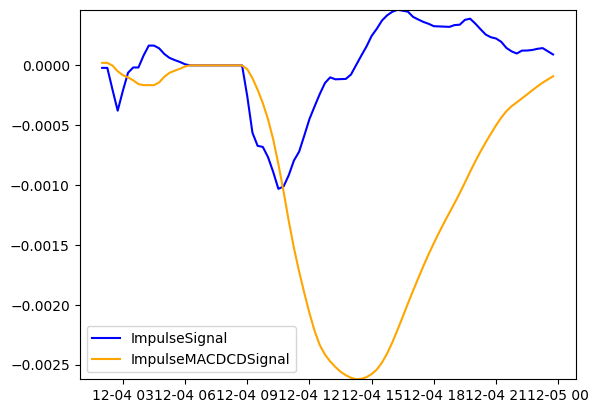

In [19]:
import matplotlib.pyplot as plt

# Assuming 'df_impulse' is your DataFrame and it has been processed by 'calc_impulse_macd' function

# Create a new figure
fig, ax = plt.subplots()

# Plot the Impulse Histogram
ax.plot(df_impulse['sh'], label='ImpulseSignal', color='blue')

# Plot the Impulse MACD CD Signal
ax.plot(df_impulse['sb'], label='ImpulseMACDCDSignal', color='orange')

# change the x axis to be much smaller and go from the max of sh and sb to the min of sh and sb
ax.set_ylim([y_min - 0.000001, y_max + 0.000001])

# Add legend
ax.legend()

# Show the plot
plt.show()


## Plotting

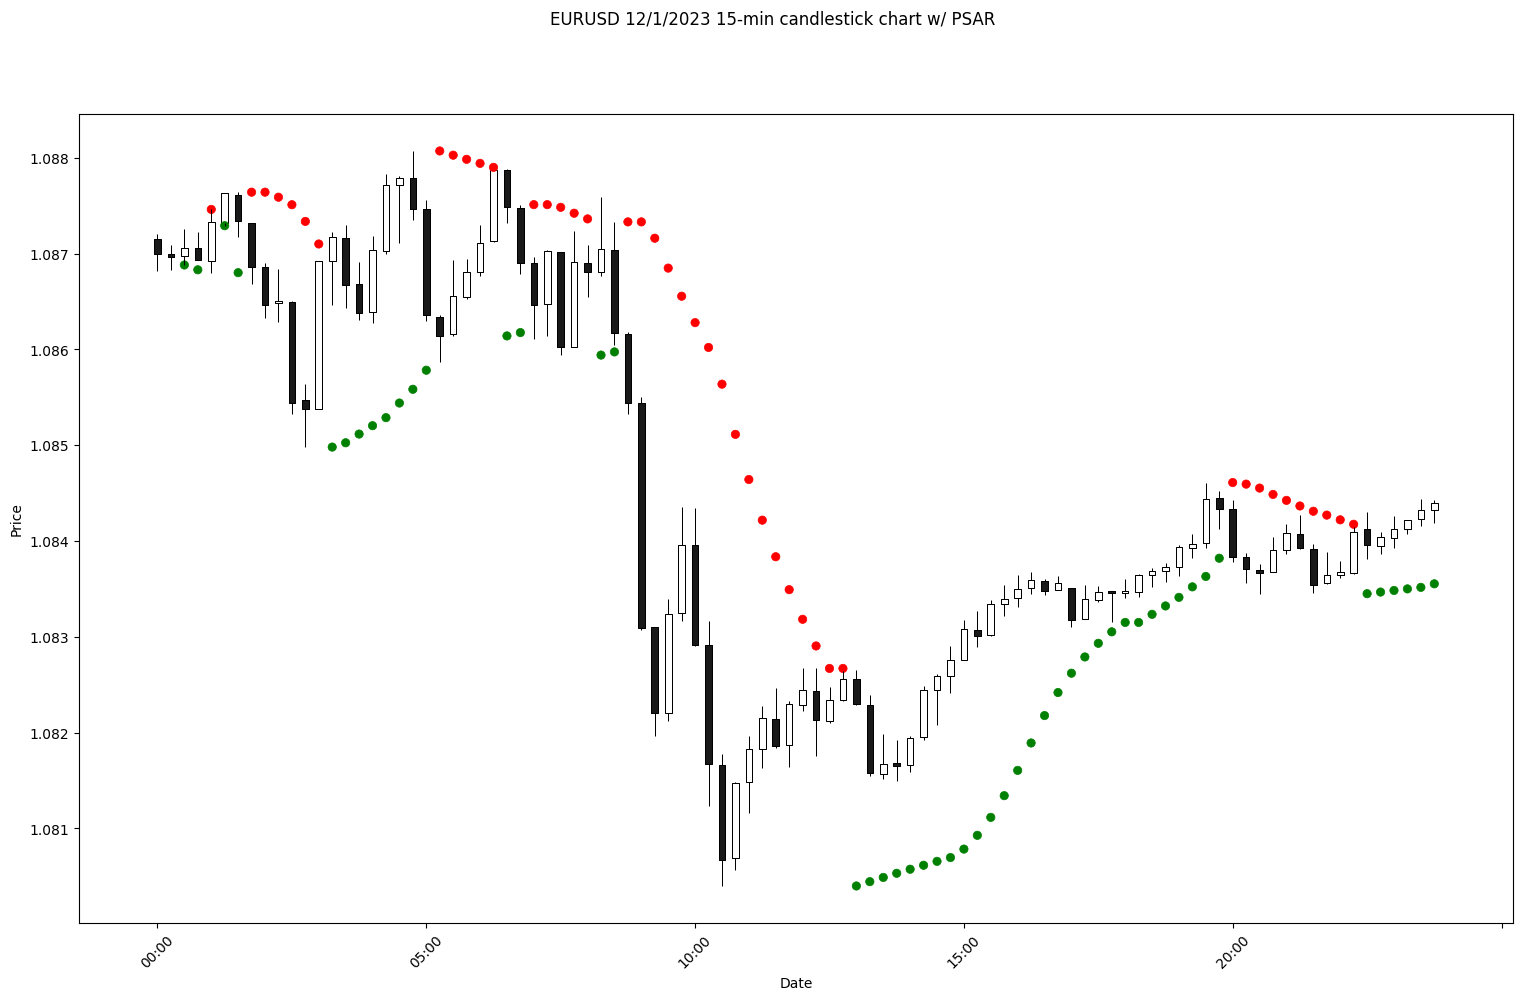

In [20]:
# Plot
fig, ax = plt.subplots()
mplfinance.plot(ohlc_dec_1_day_15_min, type='candle', ax=ax, volume=False, show_nontrading=False)
# add the psar scatterplot to the chart
plt.scatter(df_psar.index, df_psar['PSAR'], color=df_psar['Color'], lw=0.5, label='PSAR')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('EURUSD 12/1/2023 15-min candlestick chart w/ PSAR')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()

## Renko Charts

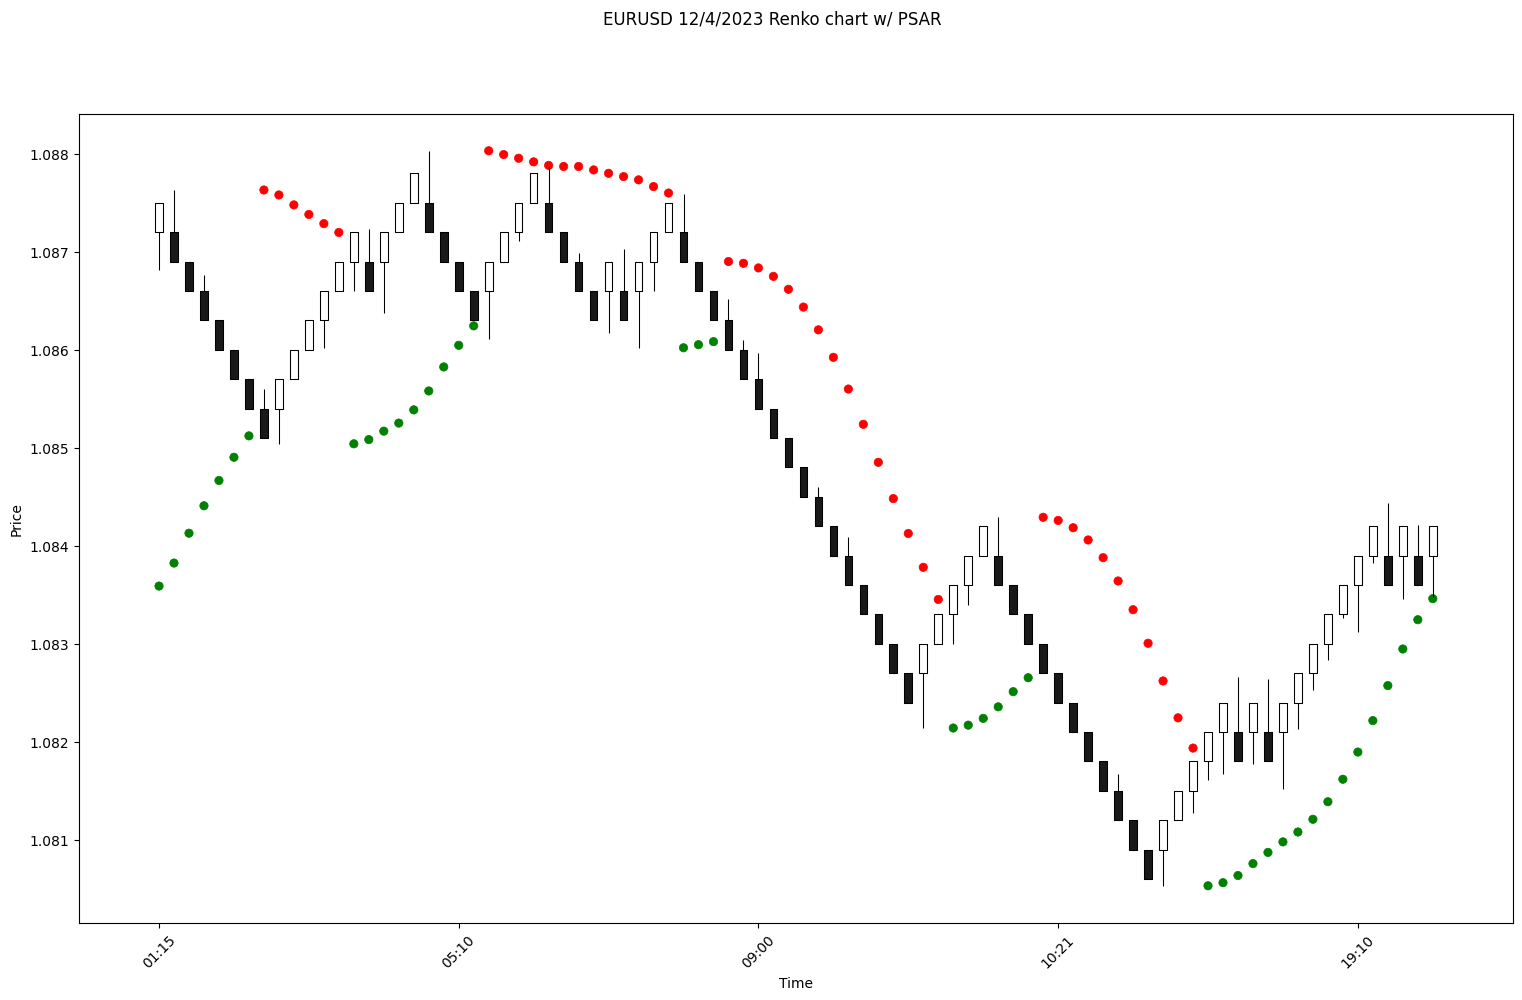

In [21]:
# create a renko chart from the ohlc_dec_1 dataframe
r = Renko(ohlc_dec_1, brick_size=0.0003)
# create a new dataframe from the renko features
renko_df_ready = r.renko_df()
renko_high = np.array(renko_df_ready['high'])
renko_low = np.array(renko_df_ready['low'])
renko_close = np.array(renko_df_ready['close'])
# recalculate psar for the renko chart
psar_renko = np.empty_like(renko_high)
for i in range(len(renko_high)):
   psar_renko[i] = psar_obj.calcPSAR(renko_high[i], renko_low[i])
# Create DataFrame
df_psar_renko = pd.DataFrame({
   'Close': renko_close,
   'PSAR': psar_renko,
})
# add a new column to the dataframe that is 'red' if the psar is above the close and 'green' if the psar is below the close
df_psar_renko['Color'] = np.where(df_psar_renko['PSAR'] > df_psar_renko['Close'], 'red', 'green')

# plot the renko chart
fig, ax = plt.subplots()
mplfinance.plot(renko_df_ready, type='candle', ax=ax, volume=False, show_nontrading=False)
# add the psar scatterplot to the chart
plt.scatter(df_psar_renko.index, df_psar_renko['PSAR'], color=df_psar_renko['Color'], lw=0.5, label='PSAR')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
fig.suptitle('EURUSD 12/4/2023 Renko chart w/ PSAR')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()



# Testing Data

## 15-min aggregation

## Renko charts (from 1 min data)

In [22]:
# Renko variable
brick_size = 0.0003

# psar variables
start = 0.02
increment = 0.02
maximum = 0.2

# impulse variables
lengthMA = 34
lengthSignal = 9

# Lot Size
lot_size = 2
per_lot = 100000

# Commissions
nova_commission = lot_size * -3
msolutions_commission = lot_size * -5

# starting balance
balance = 200000


In [31]:
# create a renko chart from the ohlc_dec_1 dataframe
r_full = Renko(ohlc, brick_size=brick_size)
# create a new dataframe from the renko features
renko_full_data = r_full.renko_df()
renko_high_full = np.array(renko_full_data['high'])
renko_low_full = np.array(renko_full_data['low'])
renko_close_full = np.array(renko_full_data['close'])
# generate a blank array for the psar_renko_full
psar_renko_full = np.empty_like(renko_high_full)
# recalculate psar for the renko chart
for i in range(len(renko_high_full)):
   psar_renko_full[i] = psar_obj.calcPSAR(renko_high_full[i], renko_low_full[i])

# append the psar_renko_full to the renko_full_data dataframe
renko_full_data['psar'] = psar_renko_full

# add a new column to the dataframe that is 'short' if the psar is above the close and 'buy' if the psar is below the close - This is the entry signal from PSAR
renko_full_data['psar_signal'] = np.where(renko_full_data['psar'] > renko_full_data['close'], 'short', 'buy')

# rename 'volume' to 'nbars'
renko_full_data = renko_full_data.rename(columns={'volume': 'nbars'})

renko_full_data.tail(10)

,open,high,low,close,nbars,psar,psar_signal
datetime,,,,,,,
2023-12-29 14:00:00,1.1055,1.10597,1.10520,1.1052,19.0,1.106517,short
2023-12-29 14:05:00,1.1052,1.10520,1.10490,1.1049,6.0,1.106455,short
2023-12-29 14:12:00,1.1049,1.10490,1.10460,1.1046,8.0,1.106361,short
2023-12-29 14:23:00,1.1046,1.10468,1.10430,1.1043,12.0,1.106220,short
2023-12-29 14:33:00,1.1043,1.10441,1.10400,1.1040,11.0,1.106028,short
2023-12-29 15:08:00,1.1043,1.10460,1.10383,1.1046,36.0,1.105785,short
2023-12-29 15:09:00,1.1046,1.10490,1.10460,1.1049,2.0,1.105511,short
2023-12-29 15:46:00,1.1046,1.10505,1.10430,1.1043,38.0,1.105276,short
2023-12-29 15:54:00,1.1043,1.10430,1.10400,1.1040,9.0,1.105073,short


In [33]:
# Add the Impulse MACD CD Signal to the renko_full_data dataframe
renko_full_data = calc_impulse_macd(renko_full_data)

# find crossover points of sh and sb by seeing when the sign of 'md' goes from being > 0 to < 0, or vice versa but don't include 0
renko_full_data['md_sign'] = np.sign(renko_full_data['md'])

# crossover would be when 'md_sign' == 1 or -1 and the previous value of 'md_sign' was 0 or -1 or 1 respectively
renko_full_data['crossover'] = np.where((renko_full_data['md_sign'] == 1) & ((renko_full_data['md_sign'].shift(1) == 0) | (renko_full_data['md_sign'].shift(1) == -1)), 1, 
                                np.where((renko_full_data['md_sign'] == -1) & ((renko_full_data['md_sign'].shift(1) == 0) | (renko_full_data['md_sign'].shift(1) == 1)), -1, 0))

# indicate the trade signal for Impulse
renko_full_data['impulse_signal'] = np.where(renko_full_data['md_sign'] == 1, 'buy', np.where(renko_full_data['md_sign'] == -1, 'short', 'none'))


In [34]:
# add a column to renko_full_data that will indicate the color of the renko brick based on the "open" and "close" columns of the renko_full_data dataframe, 
# if the open is greater than the close then the color is red, otherwise it is green
renko_full_data['color'] = np.where(renko_full_data['open'] > renko_full_data['close'], 'red', 'green')

## Entry conditions

In [36]:
# add a column that will be the entry signal for the strategy to be when both impulse_signal and psar_signal are both 'buy' or 'short'
renko_full_data['entry_signal'] = np.where((renko_full_data['psar_signal'] == 'buy') & (renko_full_data['impulse_signal'] == 'buy') & (renko_full_data['color'] == 'green'), 'buy', 
                                        np.where((renko_full_data['psar_signal'] == 'short') & (renko_full_data['impulse_signal'] == 'short') & (renko_full_data['color'] == 'red'), 'short', 'none'))

# if there was a change from 'none' to 'buy' or 'short' then that is an entry signal and replace the 'buy' or 'short' with 'entry + buy' or 'entry + short'
renko_full_data['entry_signal'] = np.where((renko_full_data['entry_signal'] != 'none') & (renko_full_data['entry_signal'].shift(1) == 'none'),
                                            'entry + ' + renko_full_data['entry_signal'], renko_full_data['entry_signal'])

# add a stop loss column that will be the entry price +/- the brick size
renko_full_data['stop_loss'] = np.where(renko_full_data['entry_signal'] == 'buy', renko_full_data['close'] - brick_size, 
                                    np.where(renko_full_data['entry_signal'] == 'short', renko_full_data['close'] + brick_size, 0))

In [ ]:
# if the color column changes from red to green or green to red then that is a reversal and 'exit' should be placed in the entry_signal column
renko_full_data['entry_signal'] = np.where((renko_full_data['color'] != renko_full_data['color'].shift(1)) & (renko_full_data['entry_signal'] != 'none'), 'exit', renko_full_data['entry_signal'])

In [ ]:
# create a first_TP column that will be the entry price + brick_size if the entry_signal is 'entry + buy' or 'entry + short'
renko_full_data['first_TP_goal'] = np.where(renko_full_data['entry_signal'] == 'entry + buy', renko_full_data['Close'] + brick_size,
                                    np.where(renko_full_data['entry_signal'] == 'entry + short', renko_full_data['Close'] - brick_size, 0))

In [ ]:
# position_count will be a cumulative count used to filter the data to the timeframe between the entry 
# and exit signals so anytime there is an "entry + buy" or "entry + short" the count should increase by 1
renko_full_data['position_count'] = np.where(renko_full_data['entry_signal'] == 'entry + buy', 1, np.where(renko_full_data['entry_signal'] == 'entry + short', 1, 0))
renko_full_data['cum_position_count'] = renko_full_data['position_count'].cumsum()
# when 'entry_signal' is 'none' then the 'cum_position_count' should be null
renko_full_data['cum_position_count'] = np.where(renko_full_data['entry_signal'] == 'none', np.nan, renko_full_data['cum_position_count'])

In [ ]:
# determine whether the exit should be sooner because the stop_loss was hit before the exit signal (look at the high/low of the brick)


In [ ]:
# Create a function that will filter to each unique cum_position_count and determine if the first_TP_goal was hit, and if it is hit, then create a new column called 'first TP hit' and put True in the column and set the stop_loss column to equal the entry price which is the value in the 'close' column where the entry_signal equals 'entry + buy' or 'entry + short'
def first_TP_hit(df):
    # find the unique values of cum_position_count that are not null
    unique_cum_position_count = df['cum_position_count'].dropna().unique()
    # loop through each unique value
    for i in unique_cum_position_count:
        # filter to just the rows where cum_position_count equals the unique value
        df_filtered = df.loc[df['cum_position_count'] == i]
        # determine whether we should be looking at high or low for the first_TP_goal
        if df_filtered['entry_signal'] == 'entry + buy':
            high_low = 'high'
        else:
            high_low = 'low'
        # fill all the columns in 'first_TP_goal' with the first value in the 'first_TP_goal' column
        df.loc[df['cum_position_count'] == i, 'first_TP_goal'] = df_filtered['first_TP_goal'].iloc[0]
        # refilter the dataframe 
        df_filtered2 = df.loc[df['cum_position_count'] == i]
        # if high_low is high then we want to see if the first_TP_goal was hit by seeing if the high is greater than or equal to the first_TP_goal
        if (high_low == 'high') & (df_filtered2['first_TP_goal'] <= df_filtered2[high_low]):
            df.loc[df['cum_position_count'] == i, 'first_TP_hit'] = True
            df.loc[df['cum_position_count'] == i, 'stop_loss'] = df_filtered2['close'].iloc[0]
        # if high_low is low then we want to see if the first_TP_goal was hit by seeing if the low is less than or equal to the first_TP_goal
        elif (high_low == 'low') & (df_filtered2['first_TP_goal'] >= df_filtered2[high_low]):
            df.loc[df['cum_position_count'] == i, 'first_TP_hit'] = True
            df.loc[df['cum_position_count'] == i, 'stop_loss'] = df_filtered2['close'].iloc[0]
    

In [ ]:
# redetermine whether the new stop_loss was hit after we took the first TP


In [ ]:
# calculate the profit/loss for each position